Da fare:
- Capire come funziona la predizione della Z con l'algoritmo mediapipe. QUindi bisognerebbe cercare il paper e capire anche come viene fatta la predizione perché è importante inserire queste informazioni all'interno del nostro report

- I valori di Z reali dell'immagine depth dovrebbero essere in metri, ma sono del tipo: 0.0003133,0.000314,0.0003169 (quindi 0.3133 mm, mi sembra un po strano). 

C'è un problema di normalizzazione.
i valori che si estraggono dalle predizioni con mediapipe sono del tipo:  -0.03380715847015381, -0.04834114760160446,-0.05878109857439995.
QUindi c'è un problema perché non sono scale uguali


# Librerie

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

2023-06-04 18:29:39.005935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Funzioni 

In [10]:
mp_holistic = mp.solutions.holistic # Holistic model (to make our detection)

def mediapipe_detection(image, model):
    h = """prende in input un'immagine RGB e restituisce i risultati del rilevamento delle mani"""
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

mp_drawing = mp.solutions.drawing_utils # Drawing utilities (to draw them)



def draw_styled_landmarks(image, results):
    h = """Funzione utilizzata per disegnare i landmark per la mano sinistra e la mano destra separatamente."""

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 



def extract_hand_landmark_coordinates(results):

    h = """funzione che estrae le coordinate dei landmark della mano sinistra e destra a partire dai risultati
        del rilevamento delle mani"""

    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks #Queste righe estraggono gli attributi left_hand_landmarks e right_hand_landmarks dall'oggetto results, che rappresentano i landmark delle mani sinistra e destra rilevate.
    left_hand_landmark_coordinates = []
    right_hand_landmark_coordinates = [] # Vengono inizializzate due liste vuote, left_hand_landmark_coordinates e right_hand_landmark_coordinates, che conterranno le coordinate dei landmark delle mani sinistra e destra.

    if left_hand_landmarks: # Questa condizione verifica se sono stati rilevati dei landmark per la mano sinistra.
        for landmark in left_hand_landmarks.landmark: #Questo ciclo itera su ciascun oggetto landmark nella lista dei landmark della mano sinistra.
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            z = landmark.z
            left_hand_landmark_coordinates.append((x, y, z)) #Le coordinate (x, y, z) vengono aggiunte alla lista left_hand_landmark_coordinates.
    if right_hand_landmarks:
        for landmark in right_hand_landmarks.landmark:
            x = int(landmark.x * image.shape[1]) # moltiplicato per la lunghezza
            y = int(landmark.y * image.shape[0]) # moltiplicato per l'altezza
            z = landmark.z
            right_hand_landmark_coordinates.append((x, y, z))

    return right_hand_landmark_coordinates, left_hand_landmark_coordinates

#La moltiplicazione per la larghezza e l'altezza dell'immagine serve a convertire le coordinate normalizzate 
# (valori compresi tra 0 e 1) fornite dai landmark in coordinate pixel all'interno dell'immagine.
#I landmark restituiti da MediaPipe sono normalizzati rispetto alle dimensioni dell'immagine di input, il che significa 
# che i valori x e y rappresentano le proporzioni rispetto alla larghezza e all'altezza dell'immagine. Moltiplicando questi 
# valori per le dimensioni effettive dell'immagine, otteniamo le coordinate in formato pixel.



def extract_real_z_values(hand_landmark_coordinates, depth_map,depth_unity=0.000125):
    h = """prende in input le coordinate dei landmark della mano e la mappa di profondità (depth map) e 
    restituisce una lista di valori z reali corrispondenti a ciascun punto dei landmark."""

    real_z_values = []
    predicted_z_values = []

    for x, y, z in hand_landmark_coordinates:
        depth = depth_map[y, x]
        real_z = depth * depth_unity #Il valore di profondità (depth) viene normalizzato dividendo per 255.0, poiché i valori della mappa di profondità di solito sono rappresentati nell'intervallo [0, 255].
        real_z_values.append(real_z)
        predicted_z_values.append(z)
    return real_z_values, predicted_z_values



def calculate_accuracy(predicted_z_values, real_z_values, threshold):
    h = """calcola l'accuratezza delle predizioni dei valori z rispetto ai valori z reali."""

    return accuracy

PREVISIONE

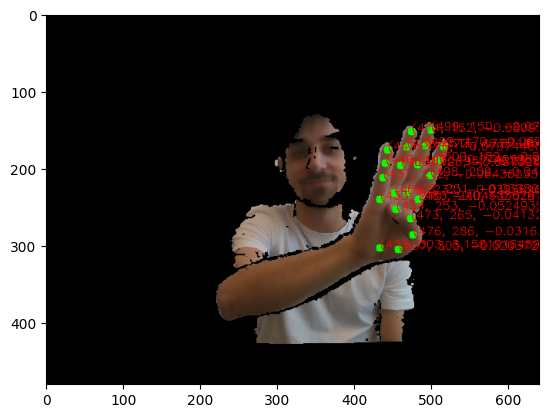

In [11]:
rgb_image = cv2.imread('Frame Depth/4/marco_38859_dx.png') # Carica l'immagine RGB
depth_map = np.fromfile('Frame Depth/4/marco_38859_dx_Depth.raw', dtype=np.uint16) # Carica la mappa di profondità RAW come array numpy

#Poiché il formato è "Z16" (16 bit di profondità), possiamo utilizzare il tipo di dati numpy 
# "np.float16" per rappresentare i valori di profondità.

image_height, image_width, _ = rgb_image.shape #estrae la dimensione dell'immagine rgb

depth_map = depth_map.reshape(image_height, image_width) # Ridimensiona la mappa di profondità all'altezza e larghezza dell'immagine RGB


# Carica il modello di MediaPipe per il rilevamento delle mani
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    image, results = mediapipe_detection(rgb_image, holistic) # Effettua la rilevazione delle mani con MediaPipe

    #Per verificare visivamente la presenza di landmark prima dell'estrazione delle coordinate
    # Draw landmarks
    """draw_styled_landmarks(image, results)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))"""

    # Estrai le coordinate dei landmark della mano destra e sinistra
    right_hand_landmark_coordinates, left_hand_landmark_coordinates = extract_hand_landmark_coordinates(results)

    #Per verificare visivamente la presenza di landmark dopo dell'estrazione delle coordinate
    for landmark in left_hand_landmark_coordinates:
        x, y, z = landmark
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Disegna un cerchio verde intorno al landmark
        cv2.putText(image, f"({x}, {y}, {z})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # Mostra le coordinate
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for landmark in right_hand_landmark_coordinates:
        x, y, z = landmark
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Disegna un cerchio verde intorno al landmark
        cv2.putText(image, f"({x}, {y}, {z})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # Mostra le coordinate
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


    # Estrai i valori di z reali e predetta dalla mappa di profondità per la mano destra
    real_z_values_right, predicted_z_values_right = extract_real_z_values(right_hand_landmark_coordinates, depth_map)

    # Estrai i valori di z reali e predetta dalla mappa di profondità per la mano sinistra
    real_z_values_left, predicted_z_values_left = extract_real_z_values(left_hand_landmark_coordinates, depth_map)


    # Calcola l'accuratezza per la mano destra

In [6]:
predicted_z_values_right

[3.1581916459799686e-07,
 -0.020372798666357994,
 -0.031637195497751236,
 -0.041328079998493195,
 -0.052493587136268616,
 -0.029778940603137016,
 -0.048515550792217255,
 -0.06285635381937027,
 -0.07342495024204254,
 -0.033805374056100845,
 -0.05184806510806084,
 -0.06716717034578323,
 -0.07752624899148941,
 -0.039361611008644104,
 -0.05732693895697594,
 -0.07195857167243958,
 -0.08095689862966537,
 -0.04633878171443939,
 -0.06436233967542648,
 -0.07405965775251389,
 -0.07974408566951752]

# Visualizzazione della DEPTH

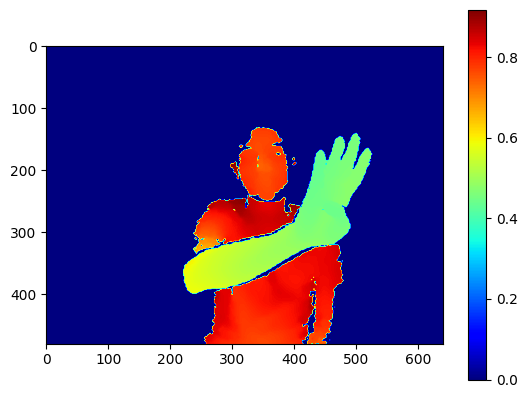

In [5]:
# Normalizza i valori di profondità
max_depth = np.max(depth_map)
depth_unity=0.000125
depth_image = depth_map * depth_unity

# Visualizza l'immagine di profondità con una scala di colore
plt.imshow(depth_image, cmap='jet')
plt.colorbar()
plt.show()

# Visualizzazione delle coordinate Z predette sull'immagine RGB

In [30]:
# Definisci la funzione di callback del mouse
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        z = depth_map[y, x] * depth_unity
        overlay_image = np.copy(output_image)
        cv2.putText(overlay_image, f'Z: {z}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.imshow('RGB Image with Depth', overlay_image)
    else:
        cv2.imshow('RGB Image with Depth', output_image)

# Crea un'immagine vuota per l'overlay
overlay_image = np.zeros_like(rgb_image)

# Copia l'immagine RGB nell'overlay
np.copyto(overlay_image, rgb_image)

# Moltiplica la depth map per depth_unity per ripristinare i valori originali
depth_map_scaled = depth_map * depth_unity

# Combina l'immagine RGB e l'overlay utilizzando l'operazione bitwise OR
output_image = cv2.bitwise_or(rgb_image, overlay_image)

# Crea una finestra per l'immagine risultante
cv2.namedWindow('RGB Image with Depth')

# Imposta la funzione di callback del mouse per la finestra
cv2.setMouseCallback('RGB Image with Depth', mouse_callback)

# Visualizza l'immagine risultante
cv2.imshow('RGB Image with Depth', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


: 

# TABELLE riassuntive

In [11]:
#image_width and image_height da rgb_image
#depth_map non normalizzato

from tabulate import tabulate

# Parte superiore della tabella - RGB IMAGE
image_info = {
    "Width": image_width,
    "Height": image_height,
    "Format": "RGB",
    "Max Z (non normalizzato)": '/',
    "Min Z (non normalizzato)": '/',
}
image_df = pd.DataFrame([image_info])

# Parte intermedia della tabella - DEPTH IMAGE
depth_info = {
    "Width": image_width,
    "Height": image_height,
    "Max Z (non normalizzato)": np.max(depth_map),
    "Min Z (non normalizzato)": np.min(depth_map),
    "Format": "DEPTH",
}
depth_df = pd.DataFrame([depth_info])

# Parte inferiore della tabella - DEPTH MEDIAPIPE
mediapipe_info = {
    "Width": image_width,
    "Height": image_height,
    "Format": "RGB",
}
mediapipe_df = pd.DataFrame([mediapipe_info])

# Concatena le tre sezioni della tabella
table_df = pd.concat([image_df, depth_df, mediapipe_df], keys=["RGB IMAGE", "DEPTH IMAGE", "DEPTH MEDIAPIPE"])

# Stampa la tabella utilizzando il modulo tabulate
table_str = tabulate(table_df, headers="keys", tablefmt="pretty")
print(table_str)






+------------------------+-------+--------+--------+--------------------------+--------------------------+
|                        | Width | Height | Format | Max Z (non normalizzato) | Min Z (non normalizzato) |
+------------------------+-------+--------+--------+--------------------------+--------------------------+
|    ('RGB IMAGE', 0)    |  640  |  480   |  RGB   |            /             |            /             |
|   ('DEPTH IMAGE', 0)   |  640  |  480   | DEPTH  |   0.00659942626953125    |           0.0            |
| ('DEPTH MEDIAPIPE', 0) |  640  |  480   |  RGB   |           nan            |           nan            |
+------------------------+-------+--------+--------+--------------------------+--------------------------+


: 